In [1]:
import numpy as np
import pandas as pd

In [2]:
train_df = pd.read_csv('../train.csv',index_col="tripid")

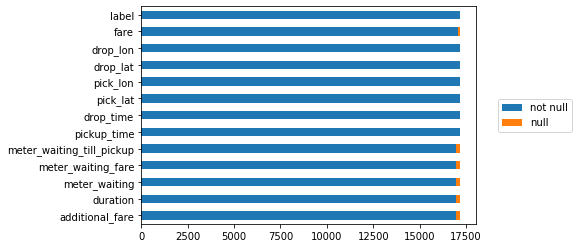

In [3]:
ax = pd.DataFrame({'not null': train_df.count(),
                   'null': train_df.isnull().sum()}).plot.barh(stacked=True)

ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5)
)

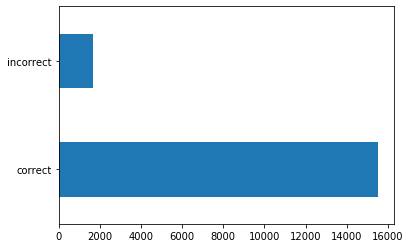

In [4]:
train_df['label'].value_counts().plot.barh()

In [5]:
from sklearn.preprocessing import label_binarize
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

RANDOM_SEED = 42  

In [6]:
labels_raw_df = train_df.loc[:, train_df.columns == 'label']
features_raw_df = train_df.drop(columns=['label'])

In [7]:
def preprocess_labels(input_labels_df):
  labels_df = input_labels_df
  labels_df = pd.DataFrame(label_binarize(labels_df, classes=['incorrrect', 'correct']))
  
  labels_df.columns = labels_df.columns
  labels_df.index = labels_df.index

  return labels_df  

In [8]:
labels_df = preprocess_labels(labels_raw_df)

In [9]:
def preprocess_features(input_features_df):
  features_df = input_features_df.copy()
  numeric_cols = features_df.columns[features_df.dtypes != "object"].values 
  non_numeric_cols = features_df.columns[features_df.dtypes == "object"].values

  #numeric
  #scale features
  scaler = RobustScaler()
  features_df[numeric_cols] = scaler.fit_transform(features_df[numeric_cols])

  #impute missing values
  imputer = KNNImputer()
  features_df[numeric_cols] = imputer.fit_transform(features_df[numeric_cols])

  #date time
  features_df['pickup_time'] = pd.to_datetime(features_df['pickup_time'])
  features_df['drop_time'] = pd.to_datetime(features_df['drop_time'])
  
  #get day of the week
  features_df['pickup_day_of_week'] = features_df['pickup_time'].dt.day_name()
  features_df['drop_day_of_week'] = features_df['drop_time'].dt.day_name()
  
  features_df['pickup_hour_float'] = features_df['pickup_time'].dt.hour + features_df['pickup_time'].dt.minute/60
  features_df['drop_hour_float'] = features_df['drop_time'].dt.hour + features_df['drop_time'].dt.minute/60

  #encode cyclic 24 hours with sin and cos
  features_df['sin_pickup_time'] = np.sin(2*np.pi*features_df.pickup_hour_float/24.)
  features_df['cos_pickup_time'] = np.cos(2*np.pi*features_df.pickup_hour_float/24.)

  features_df['sin_drop_time'] = np.sin(2*np.pi*features_df.drop_hour_float/24.)
  features_df['cos_drop_time'] = np.cos(2*np.pi*features_df.drop_hour_float/24.)

  #get weekday or weekend
  weekenddays = ['Saturday', 'Sunday']

  features_df['pickup_weekday'] = np.where(features_df['pickup_day_of_week'].isin(weekenddays), 0, 1)
  features_df['drop_weekday'] = np.where(features_df['drop_day_of_week'].isin(weekenddays), 0, 1)
  
  features_df = pd.get_dummies(features_df, columns = ['pickup_day_of_week', 'drop_day_of_week'])
  
  features_df = features_df.drop(columns=['pickup_time','drop_time'])
  
  return features_df

In [10]:
features_df = preprocess_features(features_raw_df)

In [11]:
test_features_raw_df = pd.read_csv('../test.csv',index_col="tripid")
test_features_df = preprocess_features(test_features_raw_df)

In [12]:
import xgboost as xgb

from sklearn.metrics import f1_score, confusion_matrix

from sklearn.model_selection import train_test_split

RANDOM_SEED = 4
thresh = 5

In [13]:
def f1_m(y_pred, dtrain):
  print(dtrain)
  y_true = dtrain.get_label()
  err = 1 - f1_score(y_true, np.round(y_pred))
  return 'f1_m', err

In [14]:
def modelfit(xgbmodel, x_train, y_train, x_eval, y_eval, test_features_df, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        params = xgbmodel.get_xgb_params()
        dtrain = xgb.DMatrix(x_train, label=y_train)
        cvresult = xgb.cv(params, dtrain, num_boost_round=xgbmodel.get_params()['n_estimators'], 
                          nfold=cv_folds, feval = f1, early_stopping_rounds=early_stopping_rounds, 
                          verbose_eval=False) 
        xgbmodel.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the model on the data
    xgbmodel.fit(x_train, y_train,eval_metric=f1)
        
    #Predict training set:
    y_train_pred = xgbmodel.predict(x_train)
        
    #Print model report:
    print("\nModel Report")
    print('F1 train score: {:.6f}'.format(f1_score(y_train, y_train_pred)))
    print('F1 train score macro: {:.6f}'.format(f1_score(y_train, y_train_pred, average='macro')))
    
    #Predict training set:
    y_pred = xgbmodel.predict(x_eval)
        
    #Print model report:
    print("\nModel Report")
    print('F1 train score: {:.6f}'.format(f1_score(y_eval, y_pred)))
    print('F1 train score macro: {:.6f}'.format(f1_score(y_eval, y_pred, average='macro')))

    #save test predictions
    test_pred = model.predict(test_features_df)

    submission_df = pd.read_csv('/content/drive/My Drive/Semester 7/Machine Learning/sample_submission.csv',index_col="tripid")

    np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)
    
    submission_df["prediction"] = test_pred

    submission_df.to_csv('/content/drive/My Drive/Semester 7/Machine Learning/submission_4.csv', index=True)

    feat_imp = pd.Series(xgbmodel.booster().get_fscore())
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [23]:
#Choose all predictors except target & IDcols
model = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=-1,
 scale_pos_weight=1,
 seed=27)
modelfit(model, x_train, y_train, x_eval, y_eval, test_features_df)


Model Report
F1 train score: 0.961638
F1 train score macro: 0.727458

Model Report
F1 train score: 0.955843
F1 train score macro: 0.672306


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TypeError: ignored

In [0]:
#use bayesian optimization to chose parameters 
#train model
#save model
#

def write_to_log(data, new_params=False):
    global model_type
    with open(f'flu/{model_type}_log.txt', 'a') as LOG_FILE:
        if new_params:
            LOG_FILE.write('*' * 50)

        for key, item in data.items():
            LOG_FILE.write(f'{key} : {item} \n')

        if len(data) == 1:
            LOG_FILE.write('_' * 50)
            LOG_FILE.write('\n')

        if new_params:
            LOG_FILE.write('*' * 50)


def record_history(data, new_activity=False):
    global model_type
    with open(f'flu/{model_type}_history.txt', 'a') as history:
        if new_activity:
            history.write('*' * 250 + '\n')
        else:
            history.write(str(data) + '\n')


def tree_optimization(eta, gamma, max_depth, subsample, lambda_val, num_parallel_tree):
    global H1N1_train, H1N1_test, FLU_train, FLU_test, best_H1N1, best_FLU, tree_no, model_type, x_final

    booster_params = {
        'eta': eta,
        'gamma': gamma,
        "eval_metric": "auc",
        'max_depth': int(np.around(max_depth)),
        'subsample': subsample,
        'sampling_method': 'gradient_based',
        'lambda': lambda_val,
        'grow_policy': 'lossguide',
        'num_parallel_tree': num_parallel_tree,
        'objective': 'binary:logistic',
        'verbosity': 1,
    }

    results = {}

    print("generating model")
    if model_type == 'H1N1':
        H1N1_model = xgb.train(booster_params, H1N1_train, num_boost_round=100, evals=[(H1N1_test, 'val')],
                               early_stopping_rounds=10, evals_result=results)
        num_iter = H1N1_model.best_iteration + 1
        best_score_H1N1 = H1N1_model.best_score

        if best_score_H1N1 > best_H1N1:
            print(f"Score incresed to {best_score_H1N1} from {best_H1N1}")
            best_H1N1 = best_score_H1N1
            H1N1_model = xgb.train(booster_params, H1N1_train, num_boost_round=num_iter, evals=[(H1N1_test, 'val')],
                                   evals_result=results)
            H1N1_model.save_model(f'logs/H1N1_{tree_no}_AUC_{best_H1N1}.model')
            submission_H1N1 = H1N1_model.predict(x_final)
            savetxt(f'logs/H1N1_{tree_no}_preds.txt', asarray(submission_H1N1), delimiter=',')

        score = best_score_H1N1

    else:
        FLU_model = xgb.train(booster_params, FLU_train, num_boost_round=100, evals=[(FLU_test, 'val')],
                              early_stopping_rounds=10, evals_result=results)
        num_iter = FLU_model.best_iteration + 1
        best_score_FLU = FLU_model.best_score

        if best_score_FLU > best_FLU:
            print(f"Score increased to {best_score_FLU} from {best_FLU}")
            best_FLU = best_score_FLU
            FLU_model = xgb.train(booster_params, FLU_train, num_boost_round=num_iter, evals=[(FLU_test, 'val')],
                                  evals_result=results)
            FLU_model.save_model(f'logs/FLU_{tree_no}_AUC_{best_FLU}.model')
            submission_FLU = FLU_model.predict(x_final)
            savetxt(f'flu/FLU_{tree_no}_preds.txt', asarray(submission_FLU), delimiter=',')

        score = best_score_FLU

    booster_params['ROC'] = score
    record_history(booster_params)
    tree_no += 1
    return score


def use_bayesian_optimization():
    global model_type
    max_file = open(f"max_params_{model_type}.txt", 'w')

    NN_BAYESIAN = BayesianOptimization(
        tree_optimization,
        {
            'eta': (0, 1),
            'gamma': (0, 2),
            'max_depth': (5, 15),
            'subsample': (0, 1),
            'lambda_val': (0, 3),
            'num_parallel_tree': (7, 17)
        })
    NN_BAYESIAN.maximize(init_points=50, n_iter=550, acq='ei', xi=0.0)
    write_to_log(NN_BAYESIAN.max)
    print('Best NN parameters: ', NN_BAYESIAN.max, file=max_file)


best_H1N1 = 0
best_FLU = 0
model_types = ['H1N1', 'FLU']

for model_type in model_types:
    tree_no = 0
    use_bayesian_optimization()


In [18]:
from sklearn.model_selection import GridSearchCV

In [24]:
cv_params = {'max_depth': [1,2,3,4,5,6], 'min_child_weight': [1,2,3,4]}    # parameters to be tries in the grid search
fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic'}   #other parameters, fixed for the moment 
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5, n_jobs=-1)

In [25]:
data_dmatrix = xgb.DMatrix(data=features_df,label=labels_df)

In [26]:
x_train, x_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.2,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [28]:
csv.fit(x_train, y_train.values.ravel())

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.2, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6],
                         'min_child_weight': [1, 2, 3, 4]},
             pre_dispatch='2*n_jobs', refit=True, return_trai

In [29]:
csv.best_params_

{'max_depth': 5, 'min_child_weight': 2}

In [32]:
cv_params = {'subsample': [0.8,0.9,1], 'max_delta_step': [0,1,2,4]}
fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight':2}

In [35]:
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5, n_jobs=-1) 
csv.fit(x_train, y_train.values.ravel())

csv.best_params_

{'max_delta_step': 0, 'subsample': 1}

In [36]:
cv_params = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}
fix_params['max_delta_step'] = 0
fix_params['subsample'] = 1

In [37]:
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5, n_jobs=-1) 
csv.fit(x_train, y_train.values.ravel())

csv.best_params_

{'learning_rate': 0.2}

In [39]:
pred_cv_best = csv.best_estimator_.predict(x_eval)
print('F1 score: {:.6f}'.format(f1_score(y_eval, pred_cv_best)))
print('F1 score: {:.6f}'.format(f1_score(y_eval, pred_cv_best, average='macro')))

F1 score: 0.964465
F1 score: 0.761530


In [40]:
cv_params = {'eta': [0, 0.05, 0.1, 0.3, 0.7, 1]}
fix_params['learning_rate'] = 0.2

In [41]:
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5, n_jobs=-1) 
csv.fit(x_train, y_train.values.ravel())

csv.best_params_

{'eta': 0}

In [42]:
pred_cv_best = csv.best_estimator_.predict(x_eval)
print('F1 score: {:.6f}'.format(f1_score(y_eval, pred_cv_best)))
print('F1 score: {:.6f}'.format(f1_score(y_eval, pred_cv_best, average='macro')))

F1 score: 0.964465
F1 score: 0.761530


In [45]:
fix_params['learning_rate'] = 0.2
params_final =  fix_params
print(params_final)

{'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight': 2, 'max_delta_step': 0, 'subsample': 1}


In [47]:
xgdmat_train = xgb.DMatrix(x_train, y_train)
xgdmat_test = xgb.DMatrix(x_eval, y_eval)
xgb_final = xgb.train(params_final, xgdmat_train, num_boost_round = 100)

In [64]:
import matplotlib.pyplot as plt 
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        #print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

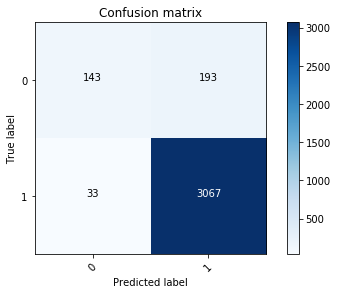

Precision =     0.941
Recall (TPR) =  0.989
F1 Score = 0.964465
Macro F1 Score = 0.761530


In [77]:
y_pred = xgb_final.predict(xgdmat_test)
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_eval, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);
print('F1 Score = {:.6f}'.format(f1_score(y_eval, y_pred)))
print('Macro F1 Score = {:.6f}'.format(f1_score(y_eval, pred_cv_best, average='macro')))

In [89]:
def predict_test_set(model, test_features_df, submission_no):
    global thresh
    
    test_pred = model.predict(xgb.DMatrix(test_features_df))
    
    test_pred [test_pred > thresh] = 1
    test_pred [test_pred <= thresh] = 0
    
    submission_df = pd.read_csv('../sample_submission.csv',index_col="tripid")
    
    # Make sure we have the rows in the same order
    np.testing.assert_array_equal(test_features_df.index.values, submission_df.index.values)
    
    # Save predictions to submission data frame
    submission_df["prediction"] = test_pred
    
    submission_df['prediction'] = submission_df['prediction'].astype(int)

    submission_df.to_csv(f'../submission{submission_no}.csv', index=True)

In [90]:
predict_test_set(xgb_final, test_features_df, 5)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 150, stop = 400, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(30, 70, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = [2,5]

eta': (0, 1),
            'gamma': (0, 2),
            'max_depth': (5, 15),
            'subsample': (0, 1),
            'lambda_val': (0, 3),
            'num_parallel_tree': (7, 17)


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}